# Import Libraries 

In [1]:
# from os import listdir
# from os.path import isfile, join

import tensorflow as tf

# import logging
import numpy as np
import pandas as pd
# import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
# logging.disable(sys.maxsize)
import random
# import pydot
# import graphviz
from tensorflow.keras.utils import plot_model
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#import pydot_ng as pydot
#pydot.find_graphviz()

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
LEARNING_RATE = 0.1
BATCH_SIZE = 8
NUM_EPOCHS = 1000

# Create Data

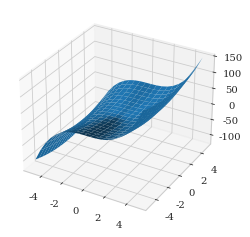

In [3]:
# x = np.random.uniform(-20, 20, 200)
# y = np.random.uniform(-20, 20, 200)
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
gridx, gridy = np.meshgrid(x, y)
out = gridy**2 + gridx**3
plt.rc('text', usetex=False)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gridx, gridy, out)

In [4]:
X = pd.DataFrame(list(zip(gridx.flatten(), gridy.flatten())), columns=["x", "y"])
Y = pd.DataFrame(out.flatten(), columns=["out"])

# Define functions for working with data

In [5]:
def train_test_split_multioutput(x_df, y_df, train_percent):
    x_len = len(x_df)
    y_len = len(y_df)
    x_indices = random.sample(range(0, x_len), int(x_len*train_percent))
    x_train = x_df.loc[x_indices]
    x_test = x_df.drop(x_indices)
    y_indices = random.sample(range(0, y_len), int(y_len*train_percent))
    y_train = y_df.loc[y_indices]
    y_test = y_df.drop(y_indices)
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()
    y_train = y_train.reset_index()
    y_test = y_test.reset_index()
    return(x_train, x_test, y_train, y_test)

# Split into training and testing

In [6]:
random.seed(1)
#X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)
X_train = X
y_train = Y

# Creating Calibrators and Inputs 

In [20]:
#the first layer of this lattice network is a calibrator - a piecewise linear function
#used to transform your data to be inside the lattice

#these are the number of points in the lattice - so using 5,5 the lattice will look like
#                v(4,4)
#o---o---o---o---o
#|   |   |   |   |
#o---o---o---o---o
#|   |   |   |   |
#o---o---o---o---o
#|   |   |   |   |
#o---o---o---o---o
#|   |   |   |   |
#o---o---o---o---o
#^(0,0)
lattice_sizes = [5, 5]
model_inputs = []
lattice_inputs = []

########x calibrator#############
x_input = tf.keras.layers.Input(shape=(1,), name='x')
model_inputs.append(x_input)
x_calibrator = tfl.layers.PWLCalibration(
   #the keypoints are what determine your piecewise linear function
   #using np.quantile tries to ensure that the data has a similar distribution
   #to the original after being transformed 
   #the number of points (here there are 5) determines the number of pieces
   #in your linear function
   input_keypoints = np.linspace(
        X_train['x'].min(), X_train['x'].max(), num=15), #np.quantile(X_train['x'], np.linspace(0.0, 1.0, num=5)),
    #saw something in the docs about data types needing to be consistent so I
    #turned everything into float32
    dtype=tf.float32,
    #when the points are transformed, they need to be somewhere inside the lattice so
    #that the function can use surrounding points to make an estimation
    #so for a lattice size of 5 we need points to be between 0 and 4 so that they're somewhere
    #inside the lattice displayed above
    output_min=0.0,
    output_max=lattice_sizes[0]-1.0,
    #I've tried this with and without the equal slopes option - the 
    #example says that this + keypoints based on quantiles help preserve
    #original distribution
    #kernel_initializer='equal_slopes',
    name='x_calib',
    monotonicity='increasing'
)(
    x_input)
lattice_inputs.append(x_calibrator)

##########y calibrator##################
y_input = tf.keras.layers.Input(shape=[1], name='y')
model_inputs.append(y_input)
y_calibrator = tfl.layers.PWLCalibration(
   input_keypoints = np.linspace(
        X_train['y'].min(), X_train['y'].max(), num=5), #np.quantile(X_train['y'], np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    output_min=0.0,
    output_max=lattice_sizes[1]-1.0,
    #kernel_initializer='constant',
    kernel_initializer='equal_slopes',
    name='y_calib',
    #kernel_regularizer=('wrinkle',0.0, 1e-4),
    #monotonicity='increasing'
)(
   y_input)
lattice_inputs.append(y_calibrator)


# Create Lattice Layer

In [21]:
#initializing the lattice
lattice = tfl.layers.Lattice(
    lattice_sizes = lattice_sizes,
    monotonicities=['increasing', 'none'],
    name='lattice',
    output_min=y_train['out'].min(),
    output_max=y_train['out'].max()
)(
    lattice_inputs) 

#pretty sure this just makes sure the output is in a reasonable range
#less sure about this layer 
# model_output = tfl.layers.PWLCalibration(
#     input_keypoints=np.linspace(y_train['out'].min(), y_train['out'].max(), 10),
#     name='output_calib',
# )(
#     lattice)


# Create Functional Model

In [22]:
model = tf.keras.models.Model(
    inputs=model_inputs,
    outputs=lattice)  # model_output

In [23]:
feature_names = ['x', 'y']
#I think this just splits up all the inputs rather than 
#passing them in as a big array
#just following the example on this one
features = np.split(
    X_train[feature_names].values.astype(np.float32),
    indices_or_sections=len(feature_names),
    axis=1)
target=y_train[['out']].values.astype(np.float32)

In [24]:
model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adam())

In [25]:
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    shuffle=False,
    # validation_split=0.1,
    verbose=0)

model.evaluate(features,target)

13/13 [==============================] - 0s 613us/step - loss: 4.5820


4.581995964050293

In [26]:
model.get_weights()

[array([[1.02843545e-01],
        [8.03841472e-01],
        [4.79756951e-01],
        [3.04728270e-01],
        [2.06786394e-01],
        [8.62488747e-02],
        [3.37562561e-02],
        [7.31468201e-04],
        [6.63757324e-04],
        [3.32901478e-02],
        [8.50913525e-02],
        [2.04088926e-01],
        [3.03624153e-01],
        [4.69427586e-01],
        [7.40752459e-01]], dtype=float32),
 array([[3.6938413e-04],
        [8.6548424e-01],
        [1.0609703e+00],
        [3.4459472e-01],
        [7.2985506e-01]], dtype=float32),
 array([[-115.07243   ],
        [-124.93075   ],
        [-124.93075   ],
        [-116.35517   ],
        [-118.38401   ],
        [ -46.909145  ],
        [ -67.15766   ],
        [ -73.35242   ],
        [ -46.734863  ],
        [ -48.350872  ],
        [  22.855398  ],
        [  -0.70013046],
        [  -3.5876708 ],
        [  23.247     ],
        [  21.974106  ],
        [  91.057236  ],
        [  67.127     ],
        [  66.67676   ],
 

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_calib (PWLCalibration)        (None, 1)            15          x[0][0]                          
__________________________________________________________________________________________________
y_calib (PWLCalibration)        (None, 1)            5           y[0][0]                          
______________________________________________________________________________________________

In [15]:
#model.summary()
#lat = model.get_layer('lattice')
#prev = model.get_layer('prev_temp_calib')
#lat.get_weights()
#prev.get_weights()
#sensible = model.get_layer('sensible_heat_diff_calib')
#sensible.get_weights()
#tf.keras.utils.plot_model(model, rankdir='LR')

# View Performance on Training Set

In [16]:
predictions = model.predict(features)

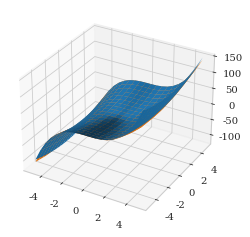

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(gridx, gridy, target.reshape(gridx.shape))
ax.plot_surface(gridx, gridy, predictions.reshape(gridx.shape))

In [18]:
abs(target-predictions).mean()

1.6174097

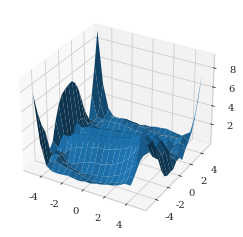

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(gridx, gridy, abs(target-predictions).reshape(gridx.shape))